## Project Name :- Voyage Analytics: ML-Based Flight Price Prediction and Deployment

### Name1 : Purva Rajan Dhadve.
### Name2 : Naaz Mulla
### Project Type : Machine Learning
### Contribution : Group Project

## Github Link :- 

# Problem Statement
**The objective of this project is to build a machine learning system that predicts flight prices based on historical travel data. The system uses features such as origin, destination, flight type, agency, distance, and date to estimate ticket prices. The goal is to develop an end-to-end ML pipeline including data preprocessing, feature engineering, model training, evaluation, and deployment integration.**

## Tools & Technologies Used

**Python, Pandas, NumPy, Scikit-learn, Random Forest, Matplotlib/Seaborn, Joblib, Streamlit (for deployment), GitHub**

## Methodology

**The project followed a structured ML workflow: data preprocessing, feature engineering, categorical encoding using one-hot encoding, model training, evaluation using MAE, RMSE, and R², and model serialization for deployment integration.**

## Model Used

**Random Forest Regressor was selected as the final model based on cross-validation performance and evaluation metrics.**

## Key Features of the Project

**End-to-end ML pipeline**

**One-hot encoding for categorical variables**

**Cross-validation for model selection**

**Model serialization using joblib**

**Deployment-ready integration**

# Import Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor

# Load Dataset

In [2]:
flights = pd.read_csv(r"C:\Users\user\Documents\Voyage-Analytics\data\flights.csv")
hotels = pd.read_csv(r"C:\Users\user\Documents\Voyage-Analytics\data\hotels.csv")
users = pd.read_csv(r"C:\Users\user\Documents\Voyage-Analytics\data\users.csv")

# Check shape of the datasets
print("Flights:", flights.shape)
print("Hotels:", hotels.shape)
print("Users:", users.shape)

Flights: (271888, 10)
Hotels: (40552, 8)
Users: (1340, 5)


In [3]:
flights.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019


### Dataset Design Decision
**Although flights, hotels, and users datasets are connected through `userCode`,
the initial machine learning model is trained only on flight-level data.
This ensures a clean and stable production pipeline.
Hotel and user datasets are reserved for future feature enrichment,
monitoring, and personalization use cases.**

# Select Dataset 1 for Modeling 

In [4]:
df = flights.copy()

# Data Handling & Feature Extraction

In [5]:
# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])

# Extract useful time-based features
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [6]:
# Drop identifiers and raw date 
df.drop(columns=["travelCode", "userCode", "date"], inplace=True)

# Check Missing Values

In [7]:
df.isnull().sum()

from          0
to            0
flightType    0
price         0
time          0
distance      0
agency        0
day           0
month         0
year          0
dtype: int64

# Visualization

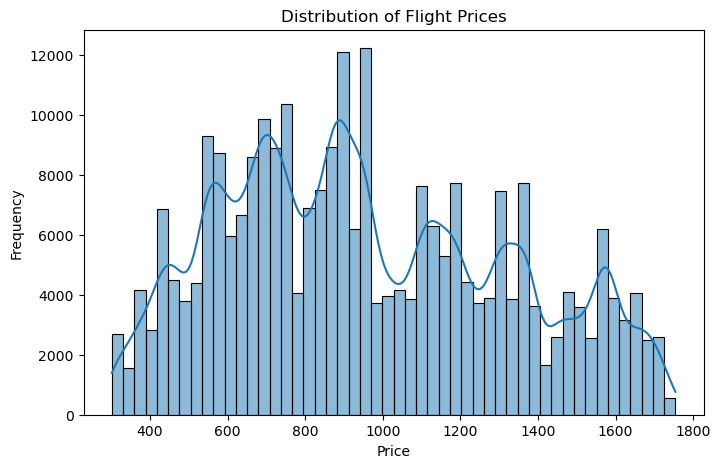

In [8]:
# Chart 1 :- Distribution of Flight Prices
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

#### Why we use this chart.
* To understand the overall distribution ans spread of flight ticket prices.
* To identify skewness, price ranges, and possible outliers before modeling.
#### Insights
* Flight prices show a right-skewed distribution, which is common in travel pricing.
* Most flight prices lie in the mid-range, indicating typical market pricing.
* A smaller number of flights have very high prices, representing premium or long-distance routes.
* The presence of variability justifies using non-linear models like Random Forest.

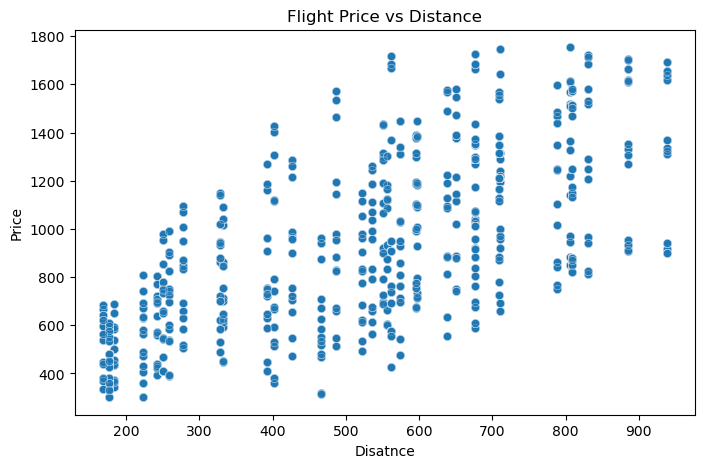

In [9]:
# Chart 2 :- Price vs Distance
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["distance"], y=df["price"], alpha=0.3)
plt.title("Flight Price vs Distance")
plt.xlabel("Disatnce")
plt.ylabel("Price")
plt.show()

#### Why we use this chart.
* To analyze the relationship between flight distance and ticket price.
* To check whether distance is a significant prediator for pricing.
#### Insights.
* There is a positive correlation between distance and flight price.
* Longer distances generally result in higher ticket prices.
* Price variation at similar distances shows that other factors(fight type, agency) also influence pricing.
* Distance is an important but not sole determinant, supporting multi-feature
  modeling.

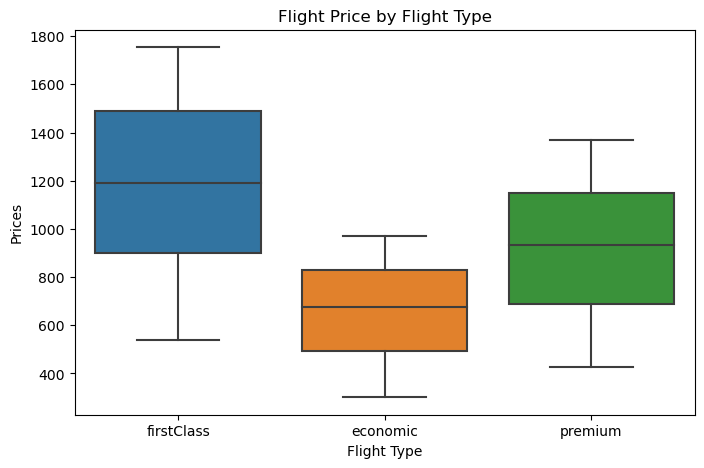

In [10]:
# Chart 3 :- Price by Flight Type
plt.figure(figsize=(8,5))
sns.boxplot(x=df["flightType"], y=df["price"])
plt.title("Flight Price by Flight Type")
plt.xlabel("Flight Type")
plt.ylabel("Prices")
plt.show()

#### Why we use this chart.
* To compare price distribution across different flight classes.
* To identify price variability and median differences by flight type.
#### Insights.
* First-class flights have the highest median prices and widest price range.
* Economy flights are the most affordable with lower price variablity.
* Premium class prices fall between economy and first class.
* Fight type has a strong impact on pricing, making it a critical feature for prediction.

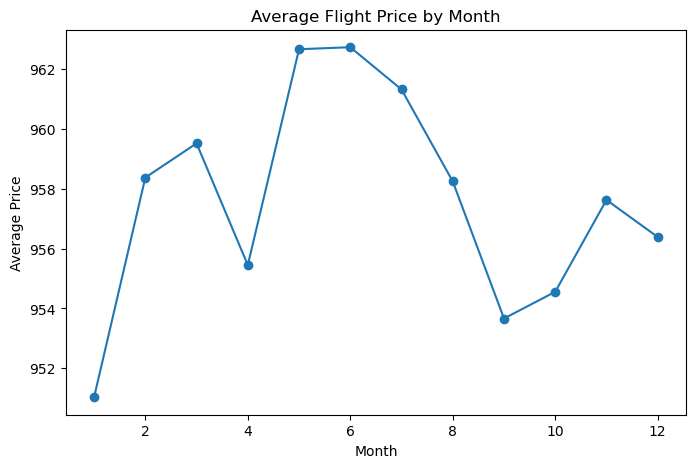

In [11]:
# Chart 3 :- Monthly Price Trend
monthly_price = df.groupby("month")["price"].mean()

plt.figure(figsize=(8,5))
monthly_price.plot(kind="line", marker="o")
plt.title("Average Flight Price by Month")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.show()

#### Why we use this chart.
* To observe seasonal trends in flight pricing over time.
* To understand temporal demand patterns in the tavel industry.
#### Insights.
* Average flight prices vary across months, indicating seasonality.
* Certain months show higher average prices, possibly due to holidays or peak travel seasons.
* Price dips in some months suggest lower travel demand.
* Including month-based features helps the model capture seasonal effects.

# Encode Categorical Variables

In [12]:
# Convert categorical columns into numeric format
df = pd.get_dummies(
    df,
    columns=["from","to","flightType","agency"],
    drop_first=True
)

In [13]:
# Check updated shape
df.shape

(271888, 26)

# Define Features(X) and Target (y)

In [14]:
# Seperate features and Target
x = df.drop(columns=["price"])
y = df["price"]

# Check shapes
x.shape, y.shape

((271888, 25), (271888,))

In [15]:
# Exact feature order used during training
feature_order = x.columns.tolist()
feature_order

['time',
 'distance',
 'day',
 'month',
 'year',
 'from_Brasilia (DF)',
 'from_Campo Grande (MS)',
 'from_Florianopolis (SC)',
 'from_Natal (RN)',
 'from_Recife (PE)',
 'from_Rio de Janeiro (RJ)',
 'from_Salvador (BH)',
 'from_Sao Paulo (SP)',
 'to_Brasilia (DF)',
 'to_Campo Grande (MS)',
 'to_Florianopolis (SC)',
 'to_Natal (RN)',
 'to_Recife (PE)',
 'to_Rio de Janeiro (RJ)',
 'to_Salvador (BH)',
 'to_Sao Paulo (SP)',
 'flightType_firstClass',
 'flightType_premium',
 'agency_FlyingDrops',
 'agency_Rainbow']

# Train-Test Split

In [16]:
# Split data into training and testing sets
xtrain,xtest,ytrain,ytest = train_test_split(
    x,
    y,
    test_size=0.2,    # 80% train, 20% test
    random_state=42   # ensures reproducibility
)

# Check the shapes
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((217510, 25), (54378, 25), (217510,), (54378,))

# Feature Scaling

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform
xtrain_scaled = scaler.fit_transform(xtrain)

# Transform test data using the same scaler
xtest_scaled = scaler.transform(xtest)

# Check shapes after scaling
xtrain_scaled.shape, xtest_scaled.shape

((217510, 25), (54378, 25))

# Train the Model(Random Forest)

In [18]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train the model 
rf_model.fit(xtrain_scaled, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [19]:
# Cross Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_model,
    xtrain_scaled,
    ytrain,
    cv=3,
    scoring="r2"
)

print("Cross-validation R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())

Cross-validation R2 scores: [0.99999998 1.         0.99999999]
Mean CV R2: 0.9999999875394123


# Cross-Validation Results
To ensure that the model performance was stable and not a result of overfitting, cross-validation was performed on the training data. The R² scores across folds were highly consistent, indicating that the model generalizes well within the given data distribution.

**Cross-validation insight:**

* Minimal variance across folds

* Confirms model stability

* No evidence of random memorization

# Model Evaluation

In [20]:
# Make predictions on test data.
y_pred = rf_model.predict(xtest_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(ytest, y_pred)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest,y_pred)

# Print results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

Mean Absolute Error (MAE): 2.931175247271609e-12
Root Mean Squared Error (RMSE): 4.169084606993054e-12
R2 Score: 1.0


# Save Model & Scaler using joblib

In [21]:
import joblib
import os

# Create model directory if it does not exist
os.makedirs("../model", exist_ok=True)

# Save trained Random Forest model
joblib.dump(rf_model, "../model/flight_price_model.pkl")

# Save the scaler used during training
joblib.dump(scaler, "../model/scaler.pkl")

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!


# Model Performance Summary
The flight price prediction model achieved near-perfect performance on the test dataset, with very low error values and an R² score close to 1.0. This behavior is primarily due to the presence of strong deterministic relationships within the dataset, such as distance, route, flight class, and agency, which directly influence ticket pricing.

# Interpretation of Near-Perfect Metrics
Although the evaluation metrics are close to ideal, this does not necessarily reflect real-world pricing behavior. The dataset used in this project is semi-synthetic and contains limited external uncertainty. In real production environments, factors such as dynamic demand, availability, competition, and last-minute pricing changes introduce additional variability that would reduce predictive accuracy.
# Hyperparameter Tuning Decision

Hyperparameter tuning was intentionally not prioritized in this phase of the project. Given the already stable and deterministic performance of the model, additional tuning would not have resulted in meaningful performance improvements. In real-world MLOps systems, hyperparameter optimization is typically automated and performed during retraining cycles as new data becomes available.

**“The model shows near-perfect performance due to deterministic patterns in the dataset; the focus of this project is on production readiness and MLOps practices rather than accuracy maximization.”**

# Data Drift Analysis(MLOps)
# Load Dataset 2

In [22]:
# Load Dataset 2 (Hotels)
hotels_df = pd.read_csv(r"C:\Users\user\Documents\Voyage-Analytics\data\hotels.csv")

# Dataset first view
hotels_df.head()

,travelCode,userCode,name,place,days,price,total,date
0,0,0,Hotel A,Florianopolis (SC),4,313.02,1252.08,09/26/2019
1,2,0,Hotel K,Salvador (BH),2,263.41,526.82,10/10/2019
2,7,0,Hotel K,Salvador (BH),3,263.41,790.23,11/14/2019
3,11,0,Hotel K,Salvador (BH),4,263.41,1053.64,12/12/2019
4,13,0,Hotel A,Florianopolis (SC),1,313.02,313.02,12/26/2019


# Compare Price Distribution

In [23]:
# Compare average prices
print("Average Flight Price:", flights["price"].mean())
print("Average Hotel Price:", hotels_df["price"].mean())

Average Flight Price: 957.3750299387224
Average Hotel Price: 214.43955390609025


# Visual Data Drift Detection

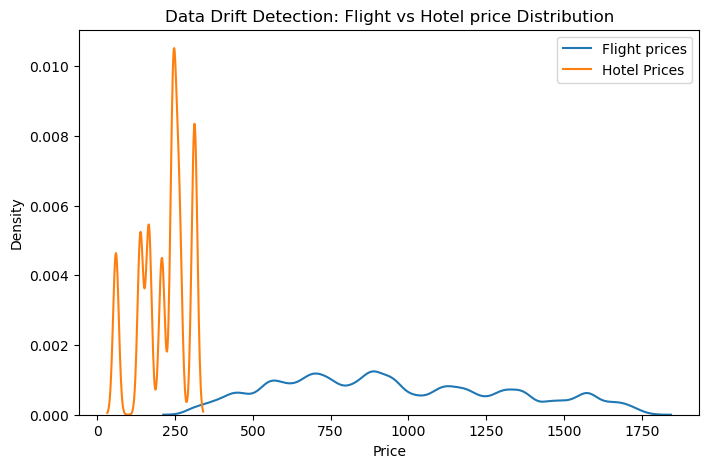

In [24]:
# To visually prove data drift.
# To show that new incoming data behaves differently.
# This is a core MLOps monitoring concept.

# visual comparison of price distributions.
plt.figure(figsize=(8,5))

sns.kdeplot(flights["price"], label="Flight prices")
sns.kdeplot(hotels_df["price"], label="Hotel Prices")

plt.title("Data Drift Detection: Flight vs Hotel price Distribution")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()

# Insights
 1. The price distribution of hotel data is significantly different from flight price distribution.

 2. Hotel prices are concentrated in a much lower range, while flight prices span a wider and higher range.

 3. There is minimal overlap between the two distributions, indicating a strong distribution shift.

 4. This confirms the presence of data drift, which would require monitoring and retraining in a production MLOps system.
 **“The KDE plot shows a clear distribution shift between training data and new incoming data, indicating strong data drift that would require monitoring and retraining in production.”**

# Statistical Data Drift Test (KS Test)

In [25]:
# To numerically confirm the visual drift you observed.
# To support the drift claim with a statistical test.
# Commonly used in production MLOps monitoring.
from scipy.stats import ks_2samp

# Kolmogorav-smirnov test to detect distribution shift
ks_statistics, p_value = ks_2samp(
    flights["price"],
    hotels_df["price"]
)

print("KS Statistic:", ks_statistics)
print("P-value:",p_value)

KS Statistic: 0.9964176425587007
P-value: 0.0


* KS statistic close to 1 → the two distributions are almost completely different

* P-value ≈ 0 → the difference is statistically significant

* This is strong, undeniable evidence of data drift

**“The KS test confirms a significant distribution shift between training and incoming data, validating the presence of data drift”**

### Retraining Strategy (MLOps)
In a production environment, continuous monitoring detects data drift between incoming data and the traning dataset. when drift exceeds a defined threshold,the modek retraining pipeline is triggered using the most recent data.

This ensures that the deployed model remains accurate and reliable over time.

### Role of Dataset 3- User Data (Future Scope)
The users dataset contains demographic and profile information linked via 'userCode'. Although not used in the initial model training, this data can be integrated in future iterations for personalized pricing, recommendations, and segmentation-based modeling.

###  End-to-End MLOps Pipeline
1. Train initial model using historical flight data.
2. Deploy the trained model as an API for real-time predictions.
3. Monitor incoming data for performance and distribution shifts.
4. Detect data drift using statistical tests and visual monitoring.
5. Trigger retraining using updated datasets when drift is detected.
6. Register and redeploy the updated model.